### Импорт

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
# импортируем данные
df = pd.read_csv(r"C:\Users\allek\OneDrive\Рабочий стол\summer_train\train_data.csv")

In [107]:
df[['Pregnancies', 'Outcome']] = df[['Outcome', 'Pregnancies']] 
df = df.rename(columns={'Pregnancies': 'Outcome_'})
df = df.rename(columns={'Outcome': 'Pregnancies'})
df = df.rename(columns={'Outcome_': 'Outcome'})

### Осмотр данных

In [108]:
df.head()

,Outcome,SkinThickness,Insulin,DiabetesPedigreeFunction,Age,Pregnancies,HOMA_IR,BMI_AGE_BOND,Glucose_category_norm,Glucose_category_prediabetes,Glucose_category_diabetes,BMI_category_underweight,BMI_category_norm,BMI_category_overweight,BMI_category_obese,Blood_Pressure_category_norm,Blood_Pressure_category_prehypertension,Blood_Pressure_category_hypertension
0,0,0.005299,0.015212,-0.490335,-1.035096,-0.528766,-0.466783,-0.915001,True,False,False,False,False,False,True,True,False,False
1,1,-0.550407,0.015212,2.413062,1.485889,1.611193,-0.165841,0.817008,False,True,False,False,False,True,False,False,True,False
2,0,-1.154976,-0.878724,0.548713,-0.948166,-0.834475,-0.566145,-1.028785,False,False,True,False,False,True,False,True,False,False
3,0,0.005299,0.015212,-0.638770,2.789848,-1.140183,0.360808,0.849012,False,False,True,False,True,False,False,True,False,False
4,1,1.021472,2.718062,-0.686270,1.138167,0.694068,2.083261,2.512501,False,False,True,False,False,False,True,False,True,False


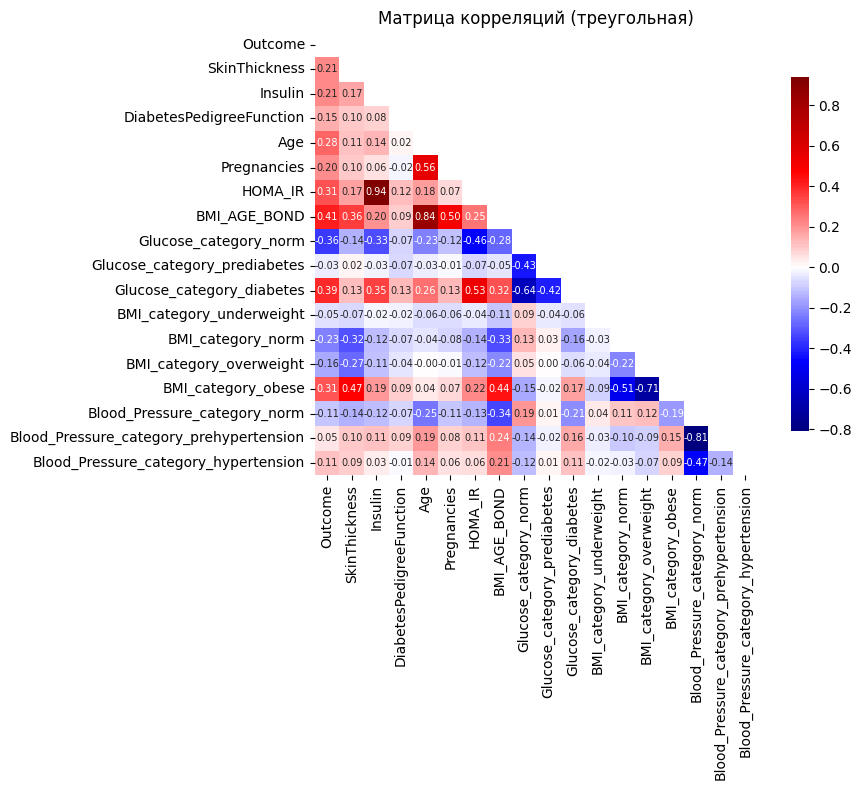

In [109]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True,
            cmap='seismic',
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8},
            annot_kws={"size": 7})  # ← Размер шрифта аннотаций

plt.title('Матрица корреляций (треугольная)')
plt.tight_layout()
plt.show()

In [110]:
drop_column = ['Blood_Pressure_category_norm', 'Blood_Pressure_category_prehypertension', 'Blood_Pressure_category_hypertension']
df = df.drop(drop_column, axis=1)

### Реализация логистической регресии

In [149]:
def sigmoid(z):
    z = np.asarray(z, dtype=float)
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

In [150]:
def binary_cross_entropy_vectorized(p_true, p_pred):
    """
    Векторизованная бинарная кросс-энтропия
    p_true: one-hot encoded метки [[0,1], [1,0], ...]
    p_pred: предсказанные вероятности [0.8, 0.2, ...]
    """
    # Защита от log(0)
    p_pred = np.clip(p_pred, 1e-15, 1 - 1e-15)
    
    # Векторизованное вычисление
    # p_true[i][1] соответствует y=1, p_true[i][0] соответствует y=0
    loss = -np.mean(p_true[:, 1] * np.log(p_pred) + p_true[:, 0] * np.log(1 - p_pred))
    
    return loss

In [151]:
X_train = np.array(df.drop('Outcome', axis=1))
Y_train = np.array(df['Outcome'])

In [152]:
# инициализация весов
w = np.full(X_train.shape[-1], -21, dtype='float')
b = 1
learning_rate_w = 0.7
learning_rate_b = 0.7
k = 612
lm_l2 = 0.1
w

array([-21., -21., -21., -21., -21., -21., -21., -21., -21., -21., -21.,
       -21., -21., -21.])

In [165]:
for epoch in range(700):
    # выборка для SGD
    rand_index = np.random.choice(X_train.shape[0], k, replace=False)
    sample_X = X_train[rand_index]
    sample_Y = Y_train[rand_index]

    # подсчет вероятности
    linear_model = w @ sample_X.T + b
    pred = sigmoid(linear_model)

    # потери
    y_one_hot = np.eye(2)[sample_Y]
    loss = binary_cross_entropy_vectorized(y_one_hot, pred)
    if epoch % 100 == 0: print(loss)

    # веса
    dz = pred - sample_Y
    dw = (1 / k) * np.dot(sample_X.T, dz)
    db = (1 / k) * np.sum(dz)

    # Преобразуйте dw и db к numpy array с правильным типом
    w -= learning_rate_w * np.asarray(dw, dtype=float)
    b -= learning_rate_b * np.asarray(db, dtype=float)

w

0.4738636830035066
0.47379216858750356
0.47463786108745537
0.47462596550760294
0.47326527376565436
0.47343241730316366
0.4730092729955478


array([  0.03601679,  -1.02862929,   0.22270584,  -0.08616644,
         0.16568956,   1.26171774,   0.63753624, -13.74198229,
       -12.87179939, -12.56748251, -21.18347464, -13.77243287,
       -12.95219268, -12.273164  ])

In [166]:
prediction = np.where(sigmoid(w @ X_train.T + b) > 0.5, 1, 0)
np.mean(prediction == Y_train)

np.float64(0.7654723127035831)

In [167]:
df_test = pd.read_csv(r"C:\Users\allek\OneDrive\Рабочий стол\summer_train\test_data.csv").drop(drop_column, axis=1)
X_test = np.array(df_test.drop('Outcome', axis=1))
Y_test = np.array(df_test['Outcome'])

In [168]:
pred_test = np.where(sigmoid(w @ X_test.T + b) > 0.5, 1, 0)
np.mean(pred_test == Y_test)

np.float64(0.7207792207792207)

#### Добавим регуляризацию

In [44]:
# инициализация весов
w = np.ones(X_train.shape[-1])
# w = np.zeros(X_train.shape[-1])
b = 0.1
learning_rate = 0.6
k = 612
lm_l2 = 0.01
lm_l1 = 0.005

In [45]:
for epoch in range(700):
    # выборка для SGD
    rand_index = np.random.choice(X_train.shape[0], k, replace=False)
    sample_X = X_train[rand_index]
    sample_Y = Y_train[rand_index]

    # подсчет вероятности
    linear_model = w @ sample_X.T + b
    pred = sigmoid(linear_model)

    # потери
    y_one_hot = np.eye(2)[sample_Y]
    loss = binary_cross_entropy_vectorized(y_one_hot, pred) + lm_l2**2 / 2 * np.sum(w**2)
    if epoch % 100 == 0: print(loss)

    # веса
    dz = pred - sample_Y
    dw = (1 / k) * np.dot(sample_X.T, dz)
    db = (1 / k) * np.sum(dz)
    L2_loss = np.sum(w)

    # Преобразуйте dw и db к numpy array с правильным типом
    w -= learning_rate * np.asarray(dw, dtype=float) + lm_l2 * L2_loss
    b -= learning_rate * np.asarray(db, dtype=float)

print(w)

1.708368730390312
0.4709430124600047
0.4710933477694605
0.4701557850413315
0.4700037152295795
0.46907799314758025
0.4691780623008272
[-0.80815534  0.24858379 -0.12022995  0.15174584  1.02754548  0.75048801
 -0.93022499  0.01462812  0.43535705  0.09260753 -0.89944818 -0.10567022
  0.61913928  0.11133459 -0.54405927 -0.04751513]


In [46]:
prediction = np.where(sigmoid(w @ X_train.T + b) > 0.5, 1, 0)
np.mean(prediction == Y_train)

np.float64(0.7752442996742671)

In [47]:
df_test = pd.read_csv(r"C:\Users\allek\OneDrive\Рабочий стол\summer_train\test_data.csv").drop
X_test = np.array(df_test.drop('Outcome', axis=1))
Y_test = np.array(df_test['Outcome'])

In [48]:
pred_test = np.where(sigmoid(w @ X_test.T + b) > 0.5, 1, 0)
np.mean(pred_test == Y_test)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 17 is different from 16)